# Outlier and Anomaly Detection For Building Experts

Weeeeeeelcome back everyone. Let's keep this data science blog train chugging along.

In this notebook I'm going to talk about outlier/anomaly detection. I'll use three approaches, starting from the least amount of effort to the most. As I mentioned at the end of the [last post](https://medium.com/onboard-blog/timeseries-forecasting-for-building-experts-part-2-trend-forecasting-ef82f594bc28), engineering in a business setting is always a tradeoff of time spent vs. ROI. When looking for outliers or anomalies in data for, say, detecting faults in machinery or equipment, faster results with more false positives pretty much always trumps slower with better specificity. Given that, we start with the simplest and quickest approach, which requires essentially no "higher-level" math or statistics -- all you need to know is your domain. After this first approach, I will then use some "naive" statistical approaches, where we look for quantifiable outliers, but use only minimal data knowledge and mostly-basic stats to do so. Finally, the third approach will be a more specialized approach to the specific type of data, and... look... I don't wanna give any spoilers here, but... it's a python machine learning package for timeseries data... it's made by a big social media company... it starts with a "P" and ends with "rophet". It's Prophet modeling. We're using Prophet again, y'all. Sorry not sorry.

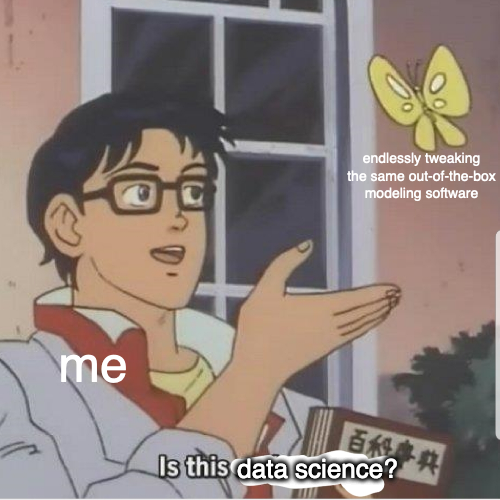

This article would be perfect for building managers, engineers, and data scientists who want to see some real-world-based approaches to finding outliers and anomalies in data. If you're trying to follow exactly everything I'm doing here, I'll call this a 4/5 on a technical level, but if you're just trying to get the gist and basic ideas to apply to some other data, let's call it a 3/5.

As always, if you want to follow along interactively, check out [the colab notebook for this post](https://githubtocolab.com/onboard-data/notebooks/blob/dev/07_outliers_and_anomalies.ipynb). However, note that you'll need [access to Onboard Data's API](https://www.onboarddata.io/sandbox) to run these notebooks. This gives access to Onboard's data sandbox, where you can fiddle with example anonymized data from real buildings on the Onboard Data Platform.

### Outliers vs. Anomalies
First things first: though they are often spoken of in the same breath, outliers differ from anomalies. In building science, both usually imply unexpected or erroneous sensor readings. "Outliers" is usually used in a statstical sense, meaning a value that is distant in some way from "typical" values. It is "morally neutral": outliers don't inherently mean anything is "wrong," per se. However, outliers may be judged as "anomalies", where an "anomaly" usually has a prescriptive implication: something is not working as expected. Because of this, an "anomaly" designation almost always relates to the domain of inference or inquiry. Overall, in this post I'll generally be looking for "outliers" of some sort, and will assess whether they are anomalies based on what question we're trying to investigate.

## Using Domain Knowledge

For the first method I'll cover here: often, assessing for outliers and anomalies is as simple as knowing the domain and knowing what values are possible. You can't have negative measurements of dimensionality (weight/height/length/volume), say, or negative numbers of occupants in a room.

Let's dig into a domain that should be very familiar: zone temperature readings. Sometimes issues come from mislabeled data. Imagine building management for one of your company's office buildings has been getting complaints about the temperature -- people are just not happy with the heat. So you've been tasked with providing an occupant thermal comfort assessment -- why are things wonky, how can we fix them? If you're doing your assessment and you saw a room temperature sensor reading 295 Fahrenheit, you'd probably worry that those occupants had careened past "not comfy" and well into "pretty dead". But if you realized there was a units mixup, and those were actually the Kelvin reading (295 Kelvin = ~70 F), you'd probably decide they were likely rather comfy indeed. The point is, you didn't need any statistics or complicated math to know those readings were not right.

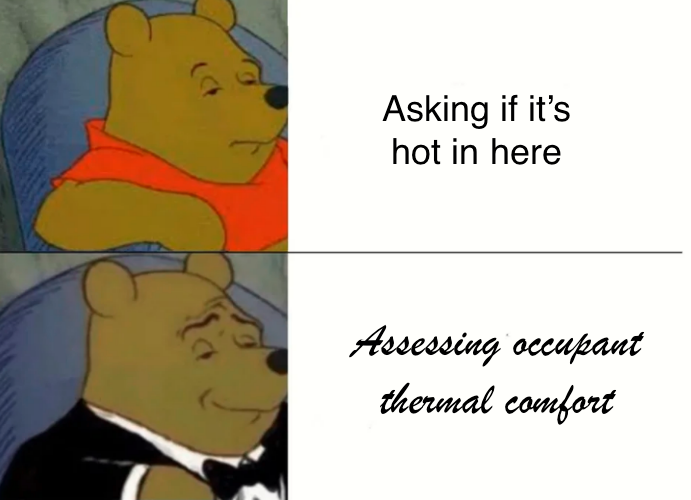

For a more data-grounded walk through such first-pass sanity checks, let's imagine someone noted some strange readings on some zone temperature sensors from fan coil units around a building (we investigated these same sensors in [a previous notebook](https://medium.com/onboard-blog/timeseries-cleaning-and-imputation-a96ab7e45eb7)). Through some game of telephone, all the information your boss got was that a batch of sensors seemed to be having problems, but you basically don't have any more information than that. All they give you is the sensor IDs, and you've been tasked with investigating them further.

In [169]:
# importing all the modules we'll need
import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta
import pytz
from onboard.client import OnboardClient
from onboard.client.models import TimeseriesQuery, PointData
from onboard.client.dataframes import points_df_from_streaming_timeseries
try: # for this you can either create a key.py file with one line: api_key = 'your api key here'
    from key import api_key
except ImportError: # or you can just input your api key when you get the prompt
  api_key = input('Please enter your api_key')

# creating our query of some temperature sensors
client = OnboardClient(api_key=api_key)

points = ['288153', '288859', '287714', '288612', '288623', '289575', '286898', '288847', '286805', '288982']
tz = pytz.timezone('UTC')
start = datetime(2021,8,1,0,0,0).replace(tzinfo=tz)
end = datetime(2022,8,1,0,0,0).replace(tzinfo=tz)

ts_query = TimeseriesQuery(point_ids = points, start = start, end = end)
query_results = client.stream_point_timeseries(ts_query)

data = points_df_from_streaming_timeseries(query_results)

data.index = pd.to_datetime(data.timestamp, format='%Y-%m-%dT%H:%M:%S.%f') # make sure the timestamp index is in datetime format
data = data.drop('timestamp', axis=1)

After taking a bit of time to query this data from Onboard's Data Platform, let's resample it and take a look at some traceplots.

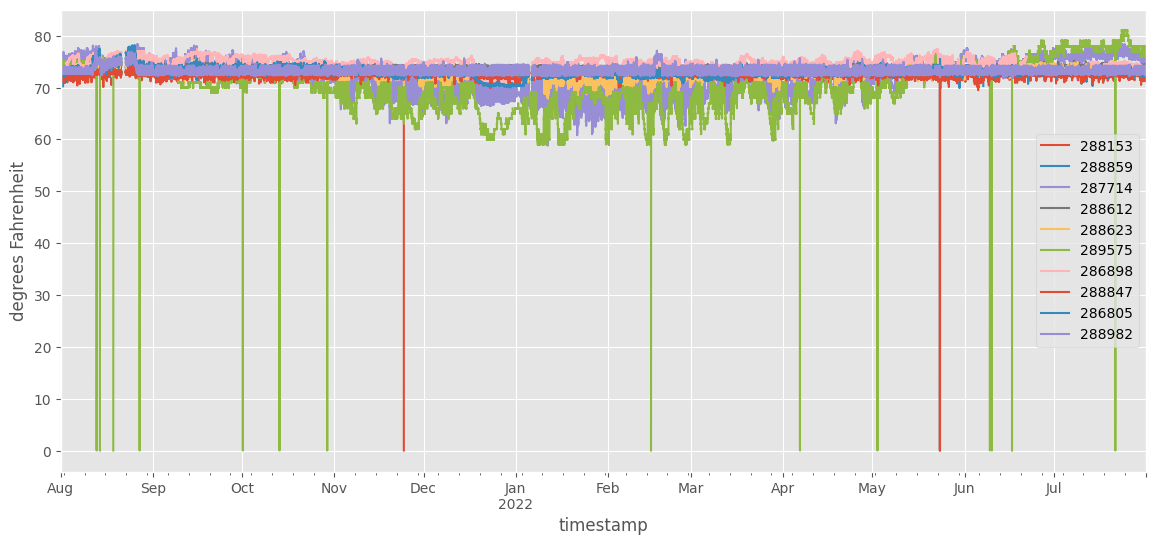

In [33]:
minute_data = data.resample('1T').mean() # resample to 1 minute timescale

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot') # set figure style
plt.rcParams["figure.figsize"] = (14,6) # set figure size

ax = minute_data.plot(ylabel = "degrees Fahrenheit")

Since we've been tasked with QAing this data for more information on how these sensors have been behaving, the first thing that jumps out for me is all those zero values. At the most superficial level of my domain knowledge, obviously those *are* valid measurements: you can certainly have zero degrees Fahrenheit. But, my instincts say that that pattern is too strange and idiosyncratic to be true zero measurements. If I were to guess, it's probably a glitch, or maybe it's expected behavior that nevertheless provides some misleading signals. For example, maybe 289575 (since that's the sensor with most of those suspicious values) sends a zero code upon some sort of restart or something along those lines, but it's being registered as the actual value 0 degrees Fahrenheit. Probably something worth investigating a bit more, perhaps digging through some documentation to suss out, but nothing we've seen so far tells me to go running and screaming to the supervising engineer.

As we've seen, this is the sort of thing that can be well managed by simply resampling the data across a longer interval, say, 10 mins? And let's just look at that suspicious sensor, 289575.

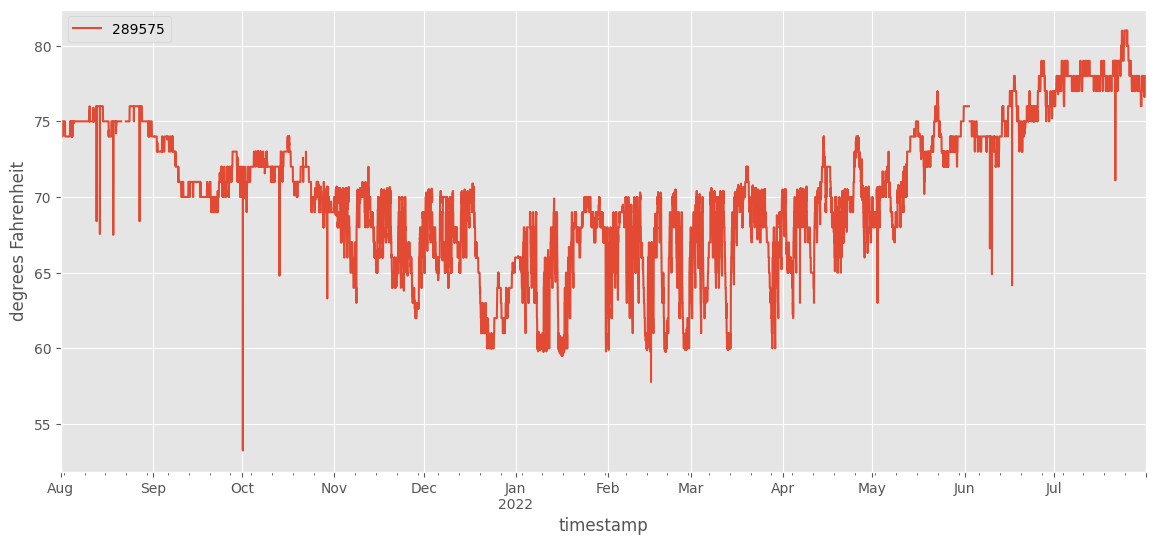

In [55]:
ax = minute_data.resample('10T').mean()[[289575]].plot(ylabel = "degrees Fahrenheit")

Now we've got much more reasonable-looking data. Taking a second pass at this, I'd say that that low-50s reading at the beginning of October is definitely worth looking into further, since it's so out of the norm: why would temperatures drop an average of ~20 degrees for 10 minutes, then jump back up just as suddenly? 

It is plausible that this is a byproduct of those (presumably erroneous) zero readings... let's zoom in a bit to early on October 1, 2021.

<img src="https://i.giphy.com/media/3ohc14lCEdXHSpnnSU/giphy.gif" />

<AxesSubplot: xlabel='timestamp', ylabel='degrees Fahrenheit'>

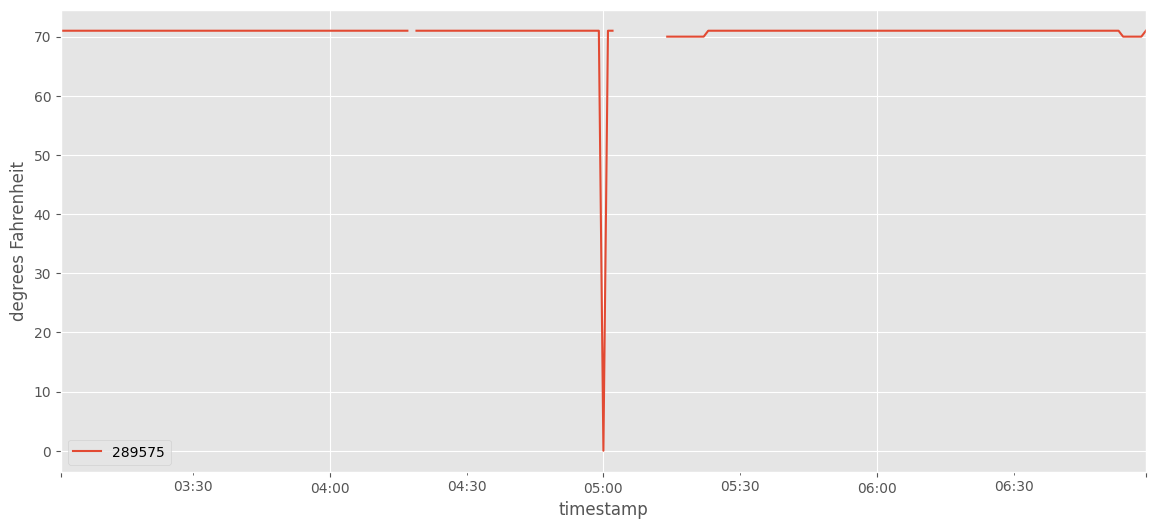

In [111]:
date_mask = (minute_data.index > '2021-10-1 03:00:00') & (minute_data.index < '2021-10-1 07:00:00')
minute_data[date_mask][[289575]].plot(ylabel = 'degrees Fahrenheit')

Ah-ha. It looks like that zero reading, combined with a few minutes of sensor down time immediately following it, led to that rather low reading. The downtime may be a coincidence, but it happening right after a zero reading partly confirms our earlier suspicions, it's probably worth looking into those other zero values a bit more to see if they follow the same trend. Once again, what we do next crucially depends on our purpose for looking at these sensors. If we're interested in usage trends, we can just sample up to, e.g., 10-min intervals and get a good idea of what average usage looks like. But if we're worried about faulty sensors, we could absolutely categorize the 0-value outliers as "anomalous", and would definitely want to look into it further. I'll leave any further exploration up to the reader, if you're interested, but I think this bit of exploration has sufficiently illustrated the first method of outlier/anomaly detection.

## Variance-Based Approaches

Looking at these zone temperature sensors gave a good idea of what an initial, visualization-based hunt for outliers and/or anomalies can look like. However, overall, I think this particular temperature data may have outlived its usefulness for the next part of this tutorial. There's just not a ton of variance to work with in that particular temperature data, meaning that more mathematical outlier measures may not be super revealing. Instead, let's revisit our chilled water supply flow (CHWS) data from the last two posts ([post one](https://medium.com/onboard-blog/feature-selection-and-timeseries-forecasting-24067e0038e3), [post two](https://medium.com/onboard-blog/timeseries-forecasting-for-building-experts-part-2-trend-forecasting-ef82f594bc28)). Chilled water supply flow measures the amount of chilled water being supplied to a cooling system, and can be thought of as the amount of effort used to cool an HVAC zone.

Imagine your company has been dealing with demand charges on energy usage, and you're looking for ways to reduce energy usage. As one approach, you could look for times of anomalous (in this case, increased) usage. Knowing that chilled water supply flow acts as a proxy for energy usage, you decide to use it to identify those times of excess consumption. First you should gather the data, and maybe do some simple passes to see where consumption falls outside of some "normal range".

In [38]:
# query and prepare data for forecasting

# look at data from the last week of July / beginning of August
start_stamp = "2022-07-18T00:00:00Z"
end_stamp = "2022-08-7T00:00:00Z"

# query the server
chws_point_id = ['518876'] # this is the chilled water supply flow (CHWS) from our Laboratory building
timeseries_query = TimeseriesQuery(point_ids=chws_point_id, start=start_stamp , end=end_stamp)
sensor_data = points_df_from_streaming_timeseries(client.stream_point_timeseries(timeseries_query))

# clean data
sensor_data.index = pd.to_datetime(sensor_data.timestamp)
sensor_data.index.name = 'time'
sensor_data = sensor_data.rename(columns={518876 : 'CHWS'})

# resample
five_min_data = sensor_data.resample('5T').mean(numeric_only=True) # resample to consistent 5-min interval
five_min_data = five_min_data.interpolate(limit=12)  # allow up to 1-hour of interpolation

# make our feature, operational status (operational = times between 10am-midnight, Monday-Friday)
five_min_data['hour'] = five_min_data.index.hour
five_min_data['weekday'] = five_min_data.index.weekday
five_min_data['workweek'] = five_min_data.apply(lambda x: x.weekday in [0,1,2,3,4], axis=1)
five_min_data['operation'] = five_min_data.apply(lambda x: x.workweek == True and (x.hour >= 10 or x.hour == 0), axis=1)

### Standard Deviation

A common technique in statistics considers outliers based on the data's standard deviations of the entire data set. Assuming a normal distribution, over 99% of data should fall within 3 standard deviations of the mean. So we want to find the mean and standard deviation for each sensor's data, and use those as cutoffs, upper and lower bounds, for the data we will call typical, versus that which we will call outliers. One way of doing this is by "z-scoring" each value, that is, encoding each value by how many standard deviations it is away from the mean.

(Note: here I'm plotting this using the seaborn objects interface, which I haven't talked about before. As of the time I'm writing this, this is a new interface to seaborn provided in the September 2022 update. If you're familiar with [ggplot](https://ggplot2.tidyverse.org/), this is a very similar method of creating and manipulating graphics. The breakneck-paced tutorial: you map your data variables (in our case, e.g. time, CHWS flow, anomaly status) to different plotting variables (x or y axis, color, size, etc.), then you choose what graphical elements to display (lines, dots, bars, etc.), and it sort of figures out what to do from there a bit automagically. The power and flexibility in this framework comes from being able to layer and combine all these pieces together. I'm kind of obssessed. Read more about how it all works [here](https://seaborn.pydata.org/tutorial/objects_interface.html).)

In [145]:
def z_score(col):
    xhat = np.nanmean(col)
    sd = np.nanstd(col)
    z = [(x - xhat)/sd for x in col]
    
    return(z)

five_min_data = five_min_data.assign(z_CHWS = lambda x: z_score(x['CHWS']))

# if anything is outside of 3 standard deviations, call it an outlier:
five_min_data['z_outlier'] = five_min_data.apply(lambda x: np.abs(x.z_CHWS) > 3, axis = 1) 

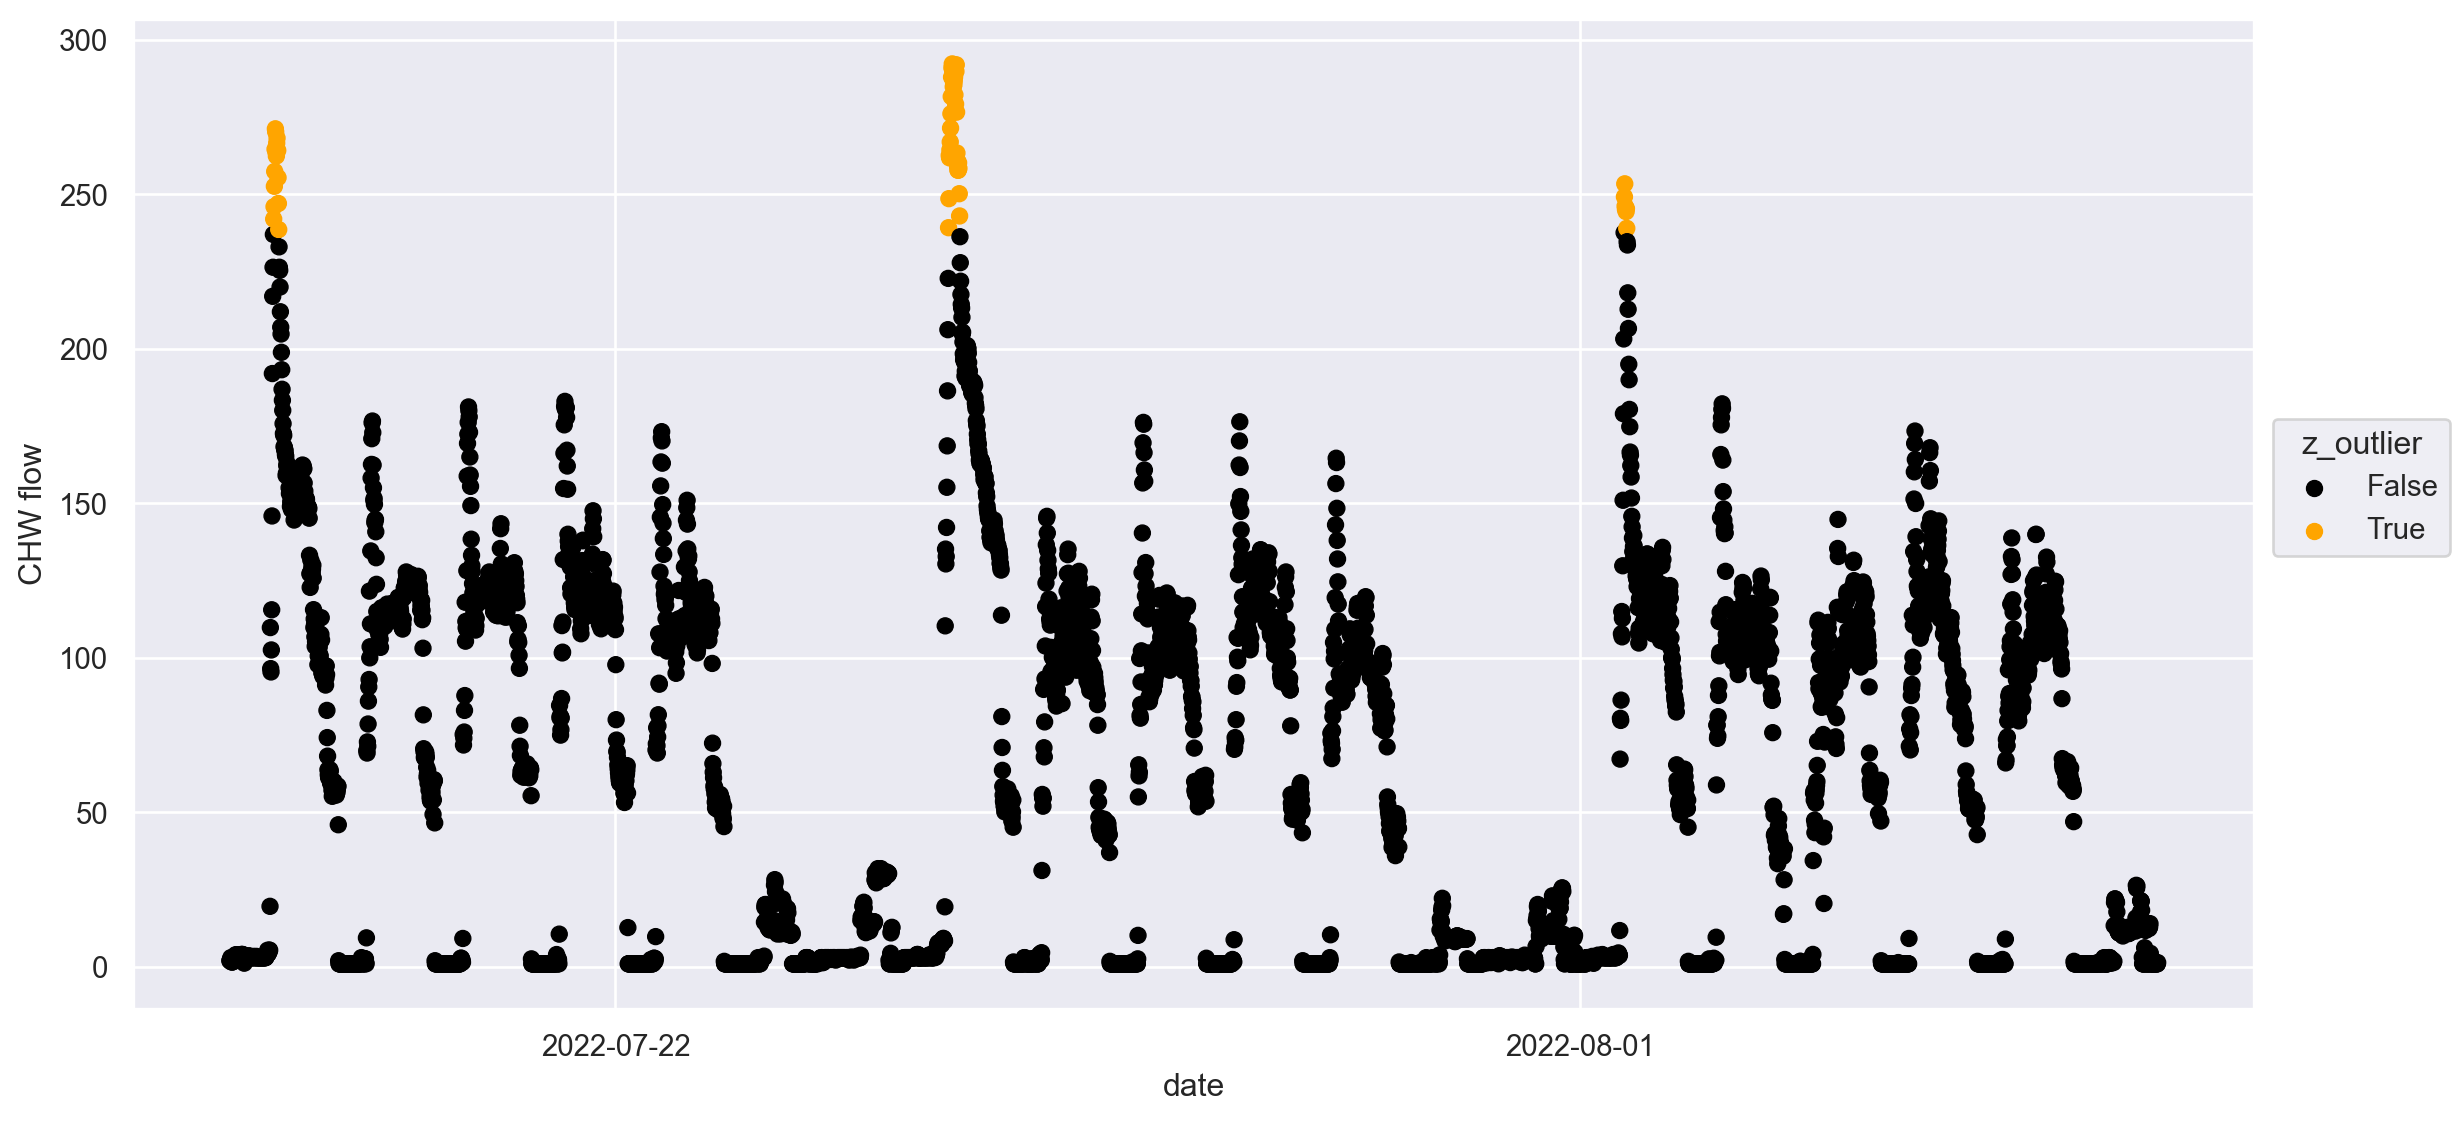

In [146]:
import seaborn.objects as so
# warnings.simplefilter("ignore", )
(
    so.Plot(data=five_min_data.reset_index(), x='time')
        .add(so.Dot(), y='CHWS', color='z_outlier')
        .layout(size=(12, 6))
        .scale(
            color=so.Nominal(('black','orange'))   
        )
        .label(x="date", y="CHW flow")
)

### Inter-quartile Range

Before even saying anything else about the standard deviation approach, I'm jumping straight into the IQR method, since I think they work well in comparison with each other. IQR first splits the data into quartiles (the four chunks of 25% of the data), and gets the range from Q1 to Q3 (the 75th percentile minus the 25th percentile), calling that the "inter-quartile range", or IQR. This is just the "middle" of the data. So, find the range of that "middle of the data" (Q3 - Q1), then say anything falling outside that IQR by a magnitude of +/- 1.5 times that range, is an outlier. Probably makes a bit more sense in explicit code:

In [149]:
def find_iqr_outliers(col):
    # qr = np.nanpercentile
    Q1, Q3 = np.nanpercentile(col, [25,75])
    IQR = Q3 - Q1
    LL = Q1 - 1.5*IQR
    UL = Q3 + 1.5*IQR

    return((col > UL) | (col < LL))

five_min_data = five_min_data.assign(iqr_outlier = lambda x: find_iqr_outliers(x['CHWS']))

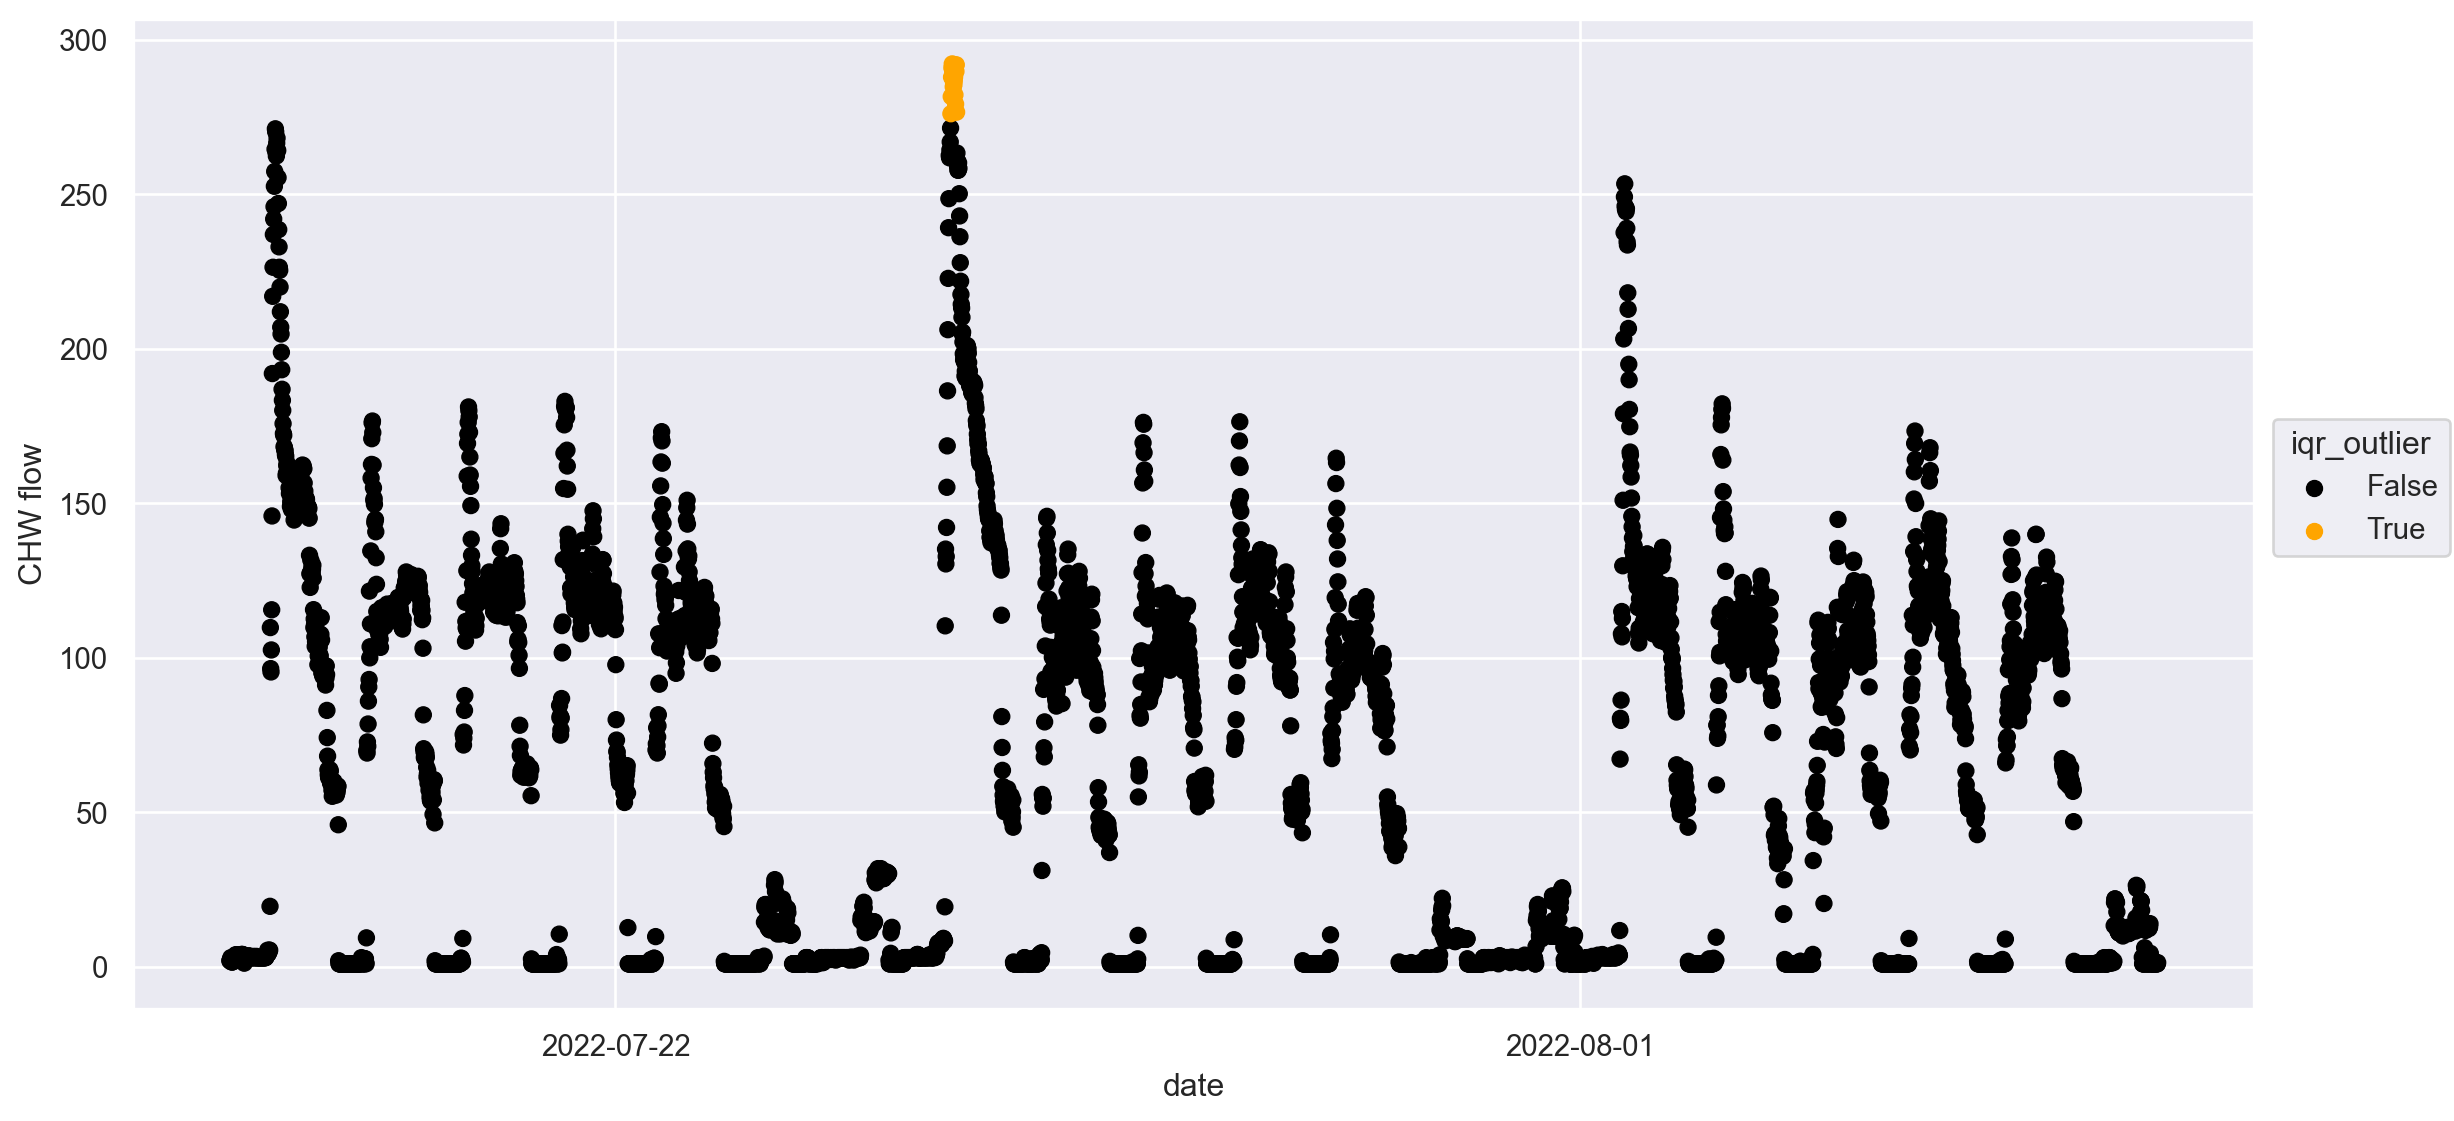

In [154]:
import seaborn.objects as so
(
    so.Plot(data=five_min_data.reset_index(), x='time')
        .add(so.Dot(), y='CHWS', color='iqr_outlier')
        .layout(size=(12, 6))
        .scale(
            color=so.Nominal(('black','orange'))   
        )
        .label(x="date", y="CHW flow")
)


In [155]:
print(f'num of sd outliers = {five_min_data[five_min_data.z_outlier == True].shape[0]}')
print(f'num of iqr outliers = {five_min_data[five_min_data.iqr_outlier == True].shape[0]}')

num of sd outliers = 58
num of iqr outliers = 18


We see that the Z score method identified more outliers than the IQR method.

These two methods work well in different scenarios. You might at first assume tat identfying *more* outliers is better, but perhaps not. Think of the IQR approach as simply measuring the spread of the data, without assuming anything about the data, whereas the standard deviation/z-score approach measures the distance of the data from some central point, based on *some theoretical distribution of values*. That "theoretical distribution of values" is the critical distinction here. The standard deviation/z-scoring approach critically assumes the mean is good at finding "the middle point" of the values, but this only works if the data are normally distributed (i.e. they make a bell curve). Looking at the plots above, we can assume this is likely not the case given the way data seems to bunch at particular parts of the y axis. We can see this more clearly by explicitly visualizing how the values distribute using a histogram.

<AxesSubplot: xlabel='CHWS', ylabel='Count'>

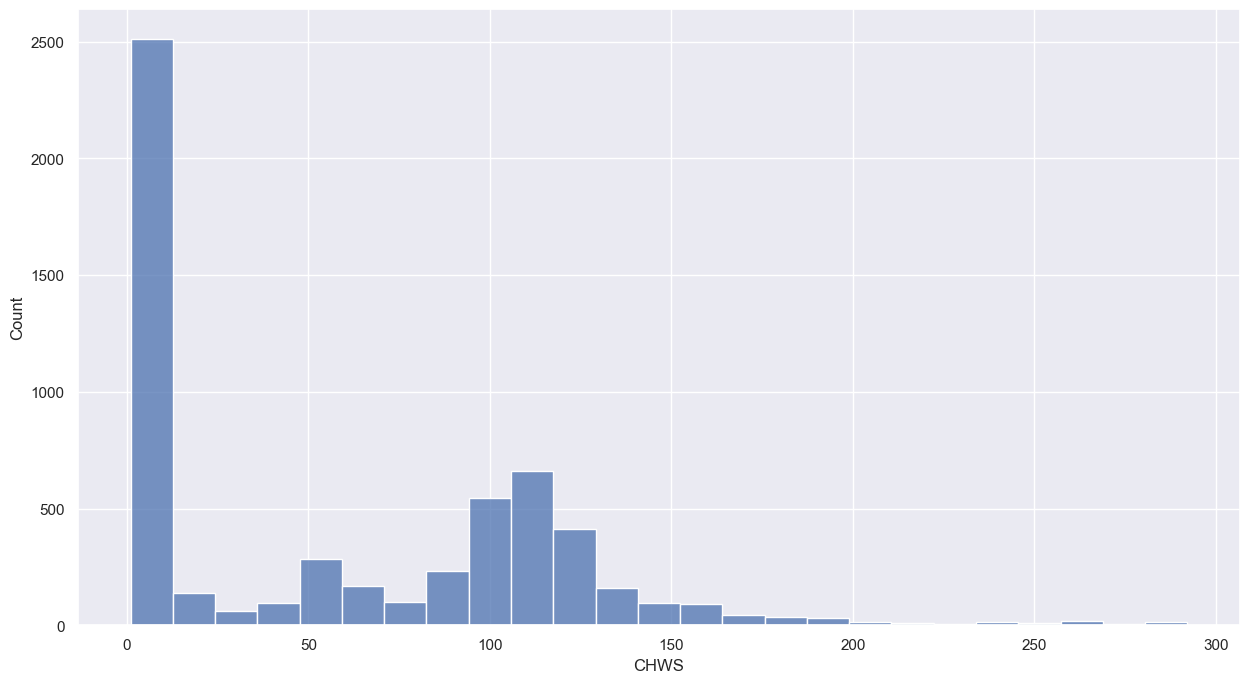

In [170]:
sns.set(rc = {"figure.figsize":(15,8)})
sns.histplot(five_min_data.CHWS)

With this plot, the CHWS flow values are now along the x axis, and the y axis is the count of how many values fall within each bin. We can see this is a rather skewed plot, with the majority of values near 0. Likewise, there are essentially two centers of mass for CHWS values, one near zero and one near ~110. This means this is not like a normal distribution, and is instead more like a bimodal distribution, meaning it has two "centers" or "peaks". This type of data, then, works better with IQR as a measure of the spread of the data, not least of all because IQR doesn't make any assumptions about parameters of the data (like what might be a good center point of the data).

So, once again, we could look further into those data flagged as outliers, to consider what might be going on there. But for now, let's consider whether we know of any other methods that might be even better at finding outliers in this data.

## Meta's Prophet Model
As always, the measures we use and the way we analyze data rely crucially on what purpose we want to use them for. If we are just interested in knowing what values fall outside of "the norm", these methods can be fruitful.

Ultimately, though, if we're looking for data that might indicate faults, or uneccesarily high consumption, we should look to somewhat more nuanced models. And look, I know what you're gonna say. I've done a bunch of Prophet models so far. I really didn't mean for it to happen, it just kind did. But hear me out: you can use it to find outliers, too! And that's honestly really great, especially for finding outliers in timeseries data!

Prophet definitely gives a more nuanced view of outliers, which can be determined more idiosyncratically than just using the spread of the data. As we talked about in [the last notebook](https://github.com/onboard-data/notebooks/blob/dev/06_Forecasting_Part_2.ipynb), it takes into account the seasonality (the "ups and downs") of the data over time, which makes a huge difference in identifying outliers (as you're about to see). But trust me, when you see all the things Prophet can offer in detecting outliers in timeseries data, well boy howdy, you're gonna be so stoked.

## Back Forecasting for Outlier Detection

[Two posts ago](https://medium.com/onboard-blog/feature-selection-and-timeseries-forecasting-24067e0038e3) we identified the `operation` feature (business operation times: Mon-Fri, 10am - midnight), and [in the last post](https://medium.com/onboard-blog/timeseries-forecasting-for-building-experts-part-2-trend-forecasting-ef82f594bc28) we used it to build a Prophet forecasting model.

As a brief overview, Prophet is specially developed to model timeseries data, and does so by modeling the timeseries seasonality (ups and downs) at a bunch of different levels. You can also add other predictors to help improve the model (in our case, we showed the `operation` regressor improved model fit to the data).

One great area of analysis with Prophet uses the model's predictions to identify outliers, or times with excessive values (of temperature, consumption, energy usage). This method is often called "back forecasting" -- you're "forecasting" for times that you already have data points for, and comparing those data points to the forecast. Essentially, the model gives a predicted value (`yhat`) and some upper and lower predictive bounds (`yhat_upper` and `yhat_lower`) based on the certainty of that prediction -- anything that falls outside of those upper or lower bounds can be considered outliers or anomalies.

Here we use a simple function to code anomalies according to those bounds. We say anything outside of the bounds is an `anomaly`, and quantify their `importance` according to a normalization of how far they are from those bounds, where larger importance values mean the actual datapoint, `y`, is further away from the prediction, and thus more "important", i.e., more worthy of further investigation.

In [161]:
# now make df_prophet, the data frame we will feed to the model
df_prophet = five_min_data[['CHWS', 'operation']].copy()
df_prophet = df_prophet.rename(columns={"CHWS": "y"})  # CHWS Flow
df_prophet['ds'] = df_prophet.index
df_prophet['ds'] = df_prophet['ds'].dt.tz_localize(None)

# need to make model here

# !pip install prophet==1.0 # install prophet if you haven't already
from prophet import Prophet
import warnings
warnings.simplefilter("ignore", FutureWarning) # this is just because prophet uses pd.append() instead of pd.concat()

# create a model with the regressor
model = Prophet(changepoint_prior_scale=0.005, yearly_seasonality=False)
model.add_regressor('operation', mode='multiplicative')
model = model.fit(df_prophet)

forecast = model.predict(df_prophet)
forecast['y'] = df_prophet['y'].reset_index(drop = True)

# function to code anomalies from result
def detect_outliers(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'y']].copy()

    forecasted['outlier'] = 0
    forecasted.loc[forecasted['yhat_upper'] < 1, 'yhat_upper'] = 1
    forecasted.loc[forecasted['yhat_lower'] < 0, 'yhat_lower'] = 0
    forecasted.loc[forecasted['y'] > forecasted['yhat_upper'], 'outlier'] = 1

    # anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['outlier'] == 1, 'importance'] = (forecasted['y'] - forecasted['yhat_upper']) / forecast['y']
    forecasted.loc[forecasted['yhat_upper'] < 10, 'importance'] = .01

    return forecasted

pred = detect_outliers(forecast)

Initial log joint probability = -233.867
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       11228.8     0.0183856       6168.32        3.39       0.339      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       11266.3   8.21682e-05       933.927   7.023e-08       0.001      255  LS failed, Hessian reset 
     199       11267.8   0.000211608       620.344      0.3242        0.64      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     254       11269.1    0.00125005       1346.26   1.452e-06       0.001      395  LS failed, Hessian reset 
     299       11269.9   4.00637e-05        693.73      0.1515       0.677      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     342       11269.9   5.01423e-08        691.99      0.2271      0.2271      514   
Optimization terminat

So, all we did here was define the model and use it to make a prediction on the data it's already seen.

And now we plot them:

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

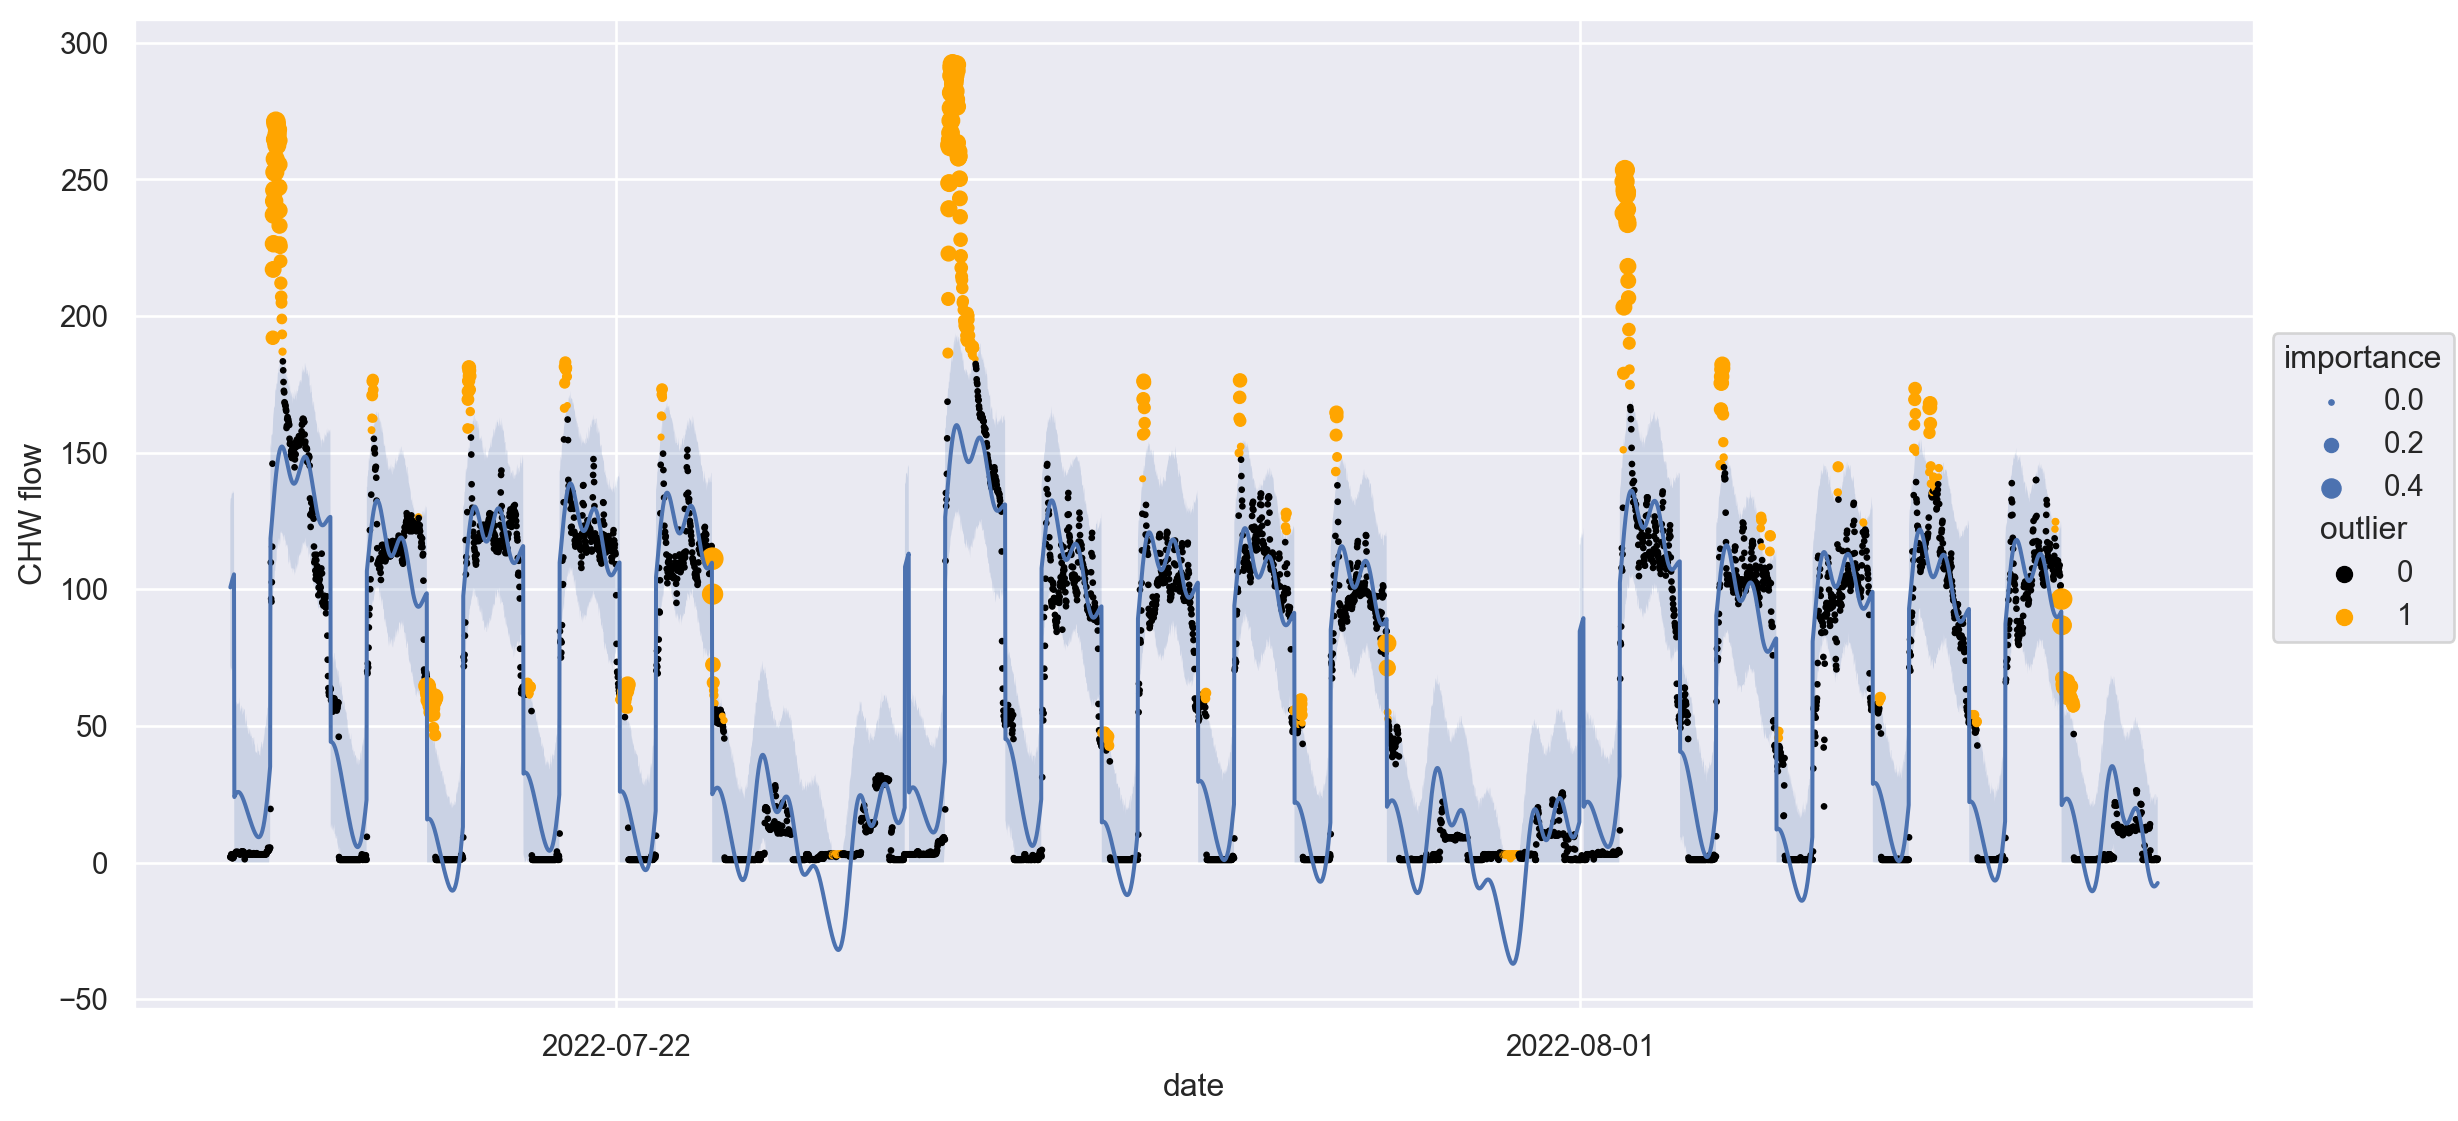

In [171]:
import seaborn.objects as so
(
    so.Plot(data=pred.astype({'outlier':str}), x='ds')
        .add(so.Line(), y='yhat')
        .add(so.Band(), ymin='yhat_lower', ymax='yhat_upper')
        .add(so.Dot(), y='y', pointsize='importance', color='outlier')
        .layout(size=(12, 6))
        .scale(
            color=so.Nominal(('black','orange'))   
        )
        .label(x="date", y="CHW flow")
)

First, we see a *lot* more outliers than were picked up with the previous variance-based metrics.

In [168]:
print(f'num of Prophet outliers = {pred[pred.outlier == 1].shape[0]}')

num of Prophet outliers = 460


But there's way more value added here than just "more" outliers. A major plus we get here is that we can see outliers based on expected values at specific datetimes of the timeseries, not just in relation to the overall spread or variance of the data. This is huge, because this method detects outliers that are within typical "variance bounds" (i.e., well within some number of standard deviations/within the IQR).

This method can help us identify excess energy/resource usage, and can give ideas for what to look into further, especially when we make use of the "importance" coding (bigger dots == bigger importance). We could certainly code distance from such boundaries in a similar way for the previous variance-based methods, but classical statistics would frown on that usage. With this model, we have some more freedom to make these types of quantifications. While we mentioned anomalies earlier, we've mostly been referring to outliers in this notebook. This method is the first time we have a really strong principled method of deciding what is an "anomaly" -- something that is probably not operating the way it "should".

This importance metric can be very helpful to see where we can save energy/time/money/resources. Off the cuff, I could also see this importance metric used in productization or automatization of fault detection, maybe by regularly employing it in monitoring meters for anomalous activity, particularly in operations that may require timely intervention.

As a general data science caveat, before jumping to any conclusions or making any decisions or plans based on this data, you should always closely consider the meta-variables at play here: the model and the data. Maybe we don't actually have enough data to accurately determine that, for example, those peaks in the graph with a bunch of orange dots flagged as outliers, are *actually* outliers. Maybe over a longer period of time we would see that those large peaks are actually rather common. In particular, we see the preponderance of those outliers falling on Mondays. Why is that? With a few more weeks under consideration, would we see that this is actually a common occurence on Mondays? If so, it would be great if the model started to pick up that regularity with more data to work from -- and Prophet *would* do so, whereas the previous variance-based methods would not. Likewise, before creating a new model, we can also pre-emptively use this observation to continue some further exploratory data analysis, and maybe consider refining our features to include something else that is happening on Mondays more than other days. We also might decide for any number of reasons that the model as we constructed it is not the best way to analyze this data, meaning we should either tweak the model parameters, or consider a different way of analyzing the data. These are the types of considerations you should make before jumping into action based on this data.

### We found the outliers -- now what?

There are many routes your continued modeling and analysis could go, which likewise depends strongly on domain knowledge/instincts and findings from further data exploration. 

In our imaginary scenario, if you're trying to find and, ultimately, reduce excess energy usage, you could now take a broader view of what's happening during those times of excessive usage. As I previously mentioned, there seems to be something going on on Mondays that leads to especially high chilled water supply flow. I would consider looking at other aspects of building operations to see where/why that spike is happening. What else is happening in the building -- with employees, tenants, other machinery and equipment -- that may contribute to those crops of outliers. This can help determine what steps could be taken to reduce energy usage. 

You likewise could do some in-the-flesh experiments to try to reduce that chilled water usage on Mondays. Perhaps start cooling the building with chilled water earlier on in the morning on Mondays, rather than waiting until it fills up with people and requires more work to cool.

Put some of these pretty graphs and explanations in a report for your boss and go get a coffee.

<div>
    <figure style="width:60%;padding:20px">
        <img src="https://imgflip.com/s/meme/Hide-the-Pain-Harold.jpg" />
        <figcaption style="text-align:left;font-size:8pt;width:50%">You, getting a coffee after absolutely demolishing that powerpoint your boss wanted.</figcaption>
    </figure>
</div>
<br />


## Conclusion

In this post we looked at three methods for outlier and anomaly detection: using general domain knowledge and data exploration, using variance-based methods, and using a more complicated model (Prophet forecasting for timeseries data). Since these approaches run from least to most complicated, and from lowest to highest effort, they can sort of cascade into each other: often you can start with the easiest approach, and continue on from there until you're satisfied with your investigation. We also distinguished between anomalies and outliers -- where "outlier" is a more neutral, data-based term, whereas "anomaly" suggests something is not operating as it should. Hope this info helped!